# Brain tumor detection project 

### 1. Pulling the data from kaggle

Run with python the script download_dataset.py and copy/paste the main folder "brain-tumor-mri-dataset" in the root directory (same path as the notebook). 

### 2. Analyzing the content of images

In [ ]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.17.1
#!pip install protobuf==3.20.3


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parameters
input_size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 32
nb_epochs = 7

In [3]:
# Some images taken of Glioma tumor's training folder
path = './brain-tumor-mri-dataset/versions/1/Training/glioma'

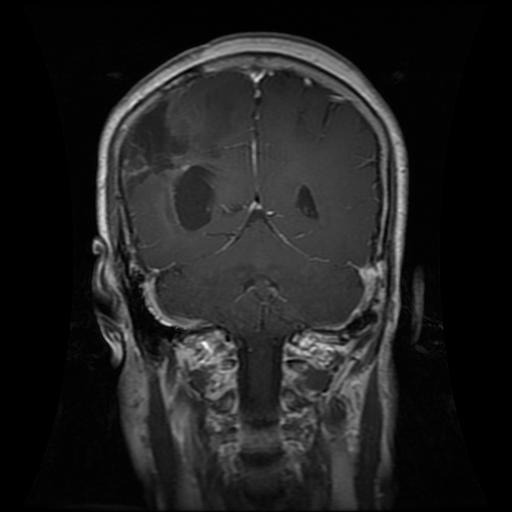

In [4]:
name = 'Tr-gl_0010.jpg' # Coronal Plan example (Front View)
fullname = f'{path}/{name}'
load_img(fullname)

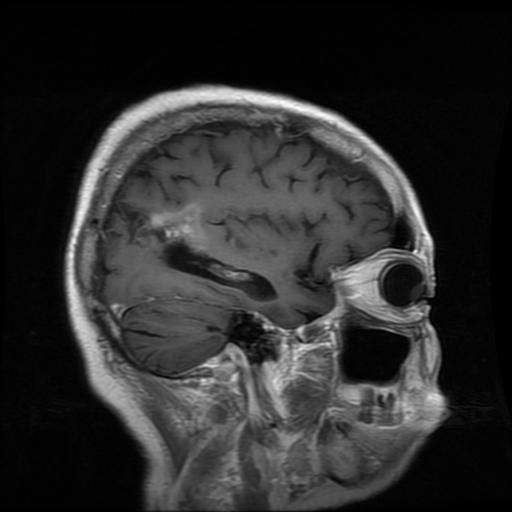

In [5]:
name = 'Tr-gl_0901.jpg' # Sagittal Plane example (Side View)
fullname = f'{path}/{name}'
img = load_img(fullname)
img

In [6]:
img_np = np.array([img])
display(img_np)
img_np.shape

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)

(1, 512, 512, 3)

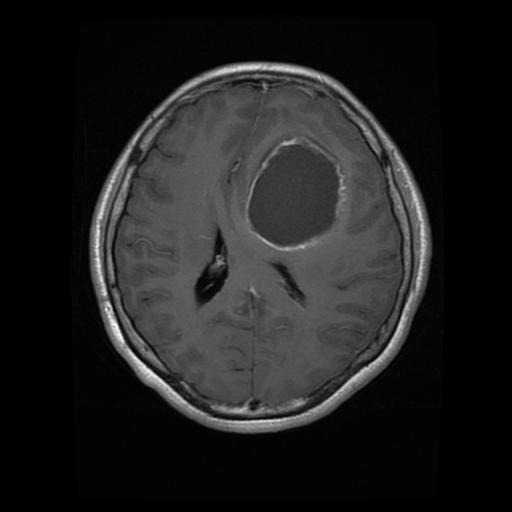

In [7]:
name = 'Tr-gl_0055.jpg' # Axial Plane example (Horizontal)
fullname = f'{path}/{name}'
load_img(fullname)

We notice some points that should be considered later at the definition of the CNN model :
- 3 types of moving planes (layer by layer) are considered for head scans (Coronal, Axial and Sagittal)
- For data augmentation, we can find for some images :
  -  slight rotation angles (<15°)
  -  vertical shifted head scans (+/- 100 pixels maximum or 10% maximum) escpecially for side view scans.
  -  slight zoom-in/zoom-out (0.9x to 1.1x)
  -  more or less contrast/brightness than all scans average.
- Another option for data augmentation is the flip but according to medical recommendations to preserve the anatomical integrity and clinical relevance of the images, this option should not be used in the case of brain MRI scans because each hemisphere or volumne of a brain has unique features. This option will not be taken into consideration later.
- Images for no tumor class have different sizes (from approx 200 x 200 pixels to 630 x 630 pixels and more). But for the other categories of scans, they have the same size 512 x 512 pixels. As a result, we should make a choice about generalizing the input size of images using resizing or padding or other image modification options.

### 3. Preparing the data for the model

In [2]:
# Loading the raw data and splitting it to execute only once !!

# Define ImageDataGenerator for loading without augmentation
data_gen = ImageDataGenerator(validation_split=0.25)

# Load training data (original, without augmentation)
train_loader = data_gen.flow_from_directory(
    'brain-tumor-mri-dataset/versions/1/Training',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_loader = data_gen.flow_from_directory(
    'brain-tumor-mri-dataset/versions/1/Training',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Save all data to variables
train_images, train_labels = zip(*(train_loader[i] for i in range(len(train_loader))))
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

val_images, val_labels = zip(*(val_loader[i] for i in range(len(val_loader))))
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Optionally save to disk
np.savez('preloaded_data.npz', train_images=train_images, train_labels=train_labels, val_images=val_images, val_labels=val_labels)

Found 4286 images belonging to 4 classes.
Found 1426 images belonging to 4 classes.


In [2]:
# In subsequent runs, load the dataset from the saved file.
"""
data = np.load('preloaded_data.npz')
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
"""

In [8]:
def aug_generator(train_images,
                train_labels,
                rotation_range = 0, 
                height_shift_range=0, 
                zoom_range=0, 
                brightness_range=None):

    # Preparing generator for training dataset
    aug_gen = ImageDataGenerator(
        rescale=1.0 / 255, 
        rotation_range=rotation_range,       
        height_shift_range=height_shift_range,  
        zoom_range=zoom_range,         
        brightness_range=brightness_range
    )

    # Generating training dataset with data augmentation
    train_ds = aug_gen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)

    return train_ds

def aug_generator_val_test(val_images, val_labels):
    aug_gen = ImageDataGenerator(
        rescale=1.0 / 255
    )

    output_ds = aug_gen.flow(val_images, val_labels, batch_size=batch_size, shuffle=False)

    return output_ds

### 2. Defining the model of CNN

#### first simple model to analyse 

In [13]:
augmented_train = aug_generator(train_images, train_labels)
augmented_val = aug_generator_val_test(val_images, val_labels)

In [14]:
# Define the initial model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', # default learning_rate = 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using augmented data
history = model.fit(
    augmented_train,
    validation_data=augmented_val,
    epochs=nb_epochs,
    batch_size=batch_size
)

base_model = model
model.save("base_model.keras")


Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.6199 - loss: 2.1457 - val_accuracy: 0.7468 - val_loss: 0.8357
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9550 - loss: 0.1297 - val_accuracy: 0.7419 - val_loss: 1.0416
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9933 - loss: 0.0370 - val_accuracy: 0.7461 - val_loss: 1.1242
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9985 - loss: 0.0180 - val_accuracy: 0.7370 - val_loss: 1.2763
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9997 - loss: 0.0061 - val_accuracy: 0.7496 - val_loss: 1.3354
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.7461 - val_loss: 1.4205
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7468 - val_loss: 1.4783


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


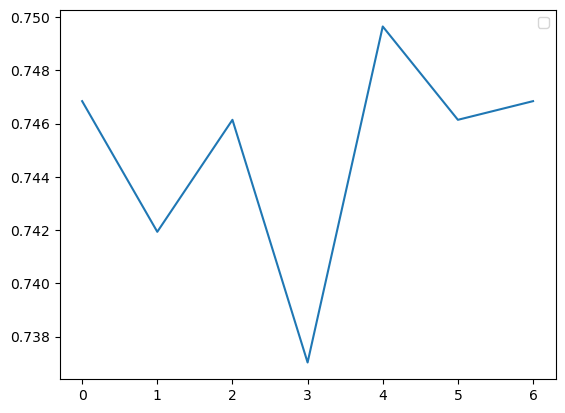

In [15]:
hist_base_model = history.history
plt.plot(hist_base_model['val_accuracy'])

plt.xticks(np.arange(nb_epochs))
plt.legend()

The initial model has a maximum accuracy score of 0.757 on the validation dataset, which is an good score as a starting model.<br>
Next, we will be tuning some parameters in the goal of enhancing the accuracy of the model.

In [16]:
# test dataset generator with resizing
test_gen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
)

# Test generator
test_ds = test_gen.flow_from_directory(
    'brain-tumor-mri-dataset/versions/1/Testing',              # Path to dataset directory
    target_size=input_size,  # Resize images
    batch_size=32,           # Number of images per batch
    class_mode='categorical',# For multi-class classification
    shuffle=False             # Shuffle data to ensure randomness
)

# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = base_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8457 - loss: 0.9294
Test Accuracy: 0.88


#### Fine-tuning the data augmentation parameters

In [9]:
def train_model_data_augmentation(augmented_train):
    # Train the model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    # Compile the model
    model.compile(optimizer='adam', # default learning_rate = 0.001
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model using augmented data
    history = model.fit(
        augmented_train,
        validation_data=augmented_val,
        epochs=nb_epochs,
        batch_size=batch_size
    )
    
    return history.history

5
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.6112 - loss: 1.8125 - val_accuracy: 0.6403 - val_loss: 1.0908
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.8898 - loss: 0.3060 - val_accuracy: 0.7237 - val_loss: 1.0676
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - accuracy: 0.9390 - loss: 0.1784 - val_accuracy: 0.6992 - val_loss: 1.2738
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.9660 - loss: 0.1093 - val_accuracy: 0.7083 - val_loss: 1.2953
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - accuracy: 0.9816 - loss: 0.0780 - val_accuracy: 0.7118 - val_loss: 1.5647
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.9754 - loss: 0.0718 - val_accuracy: 0.7223 - val_loss: 1.5100
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9826 - loss: 0.0636 - val_accuracy: 0.7272 - val_loss: 1.6518
10
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 370ms/step - accuracy: 0.6067 - loss: 1.80

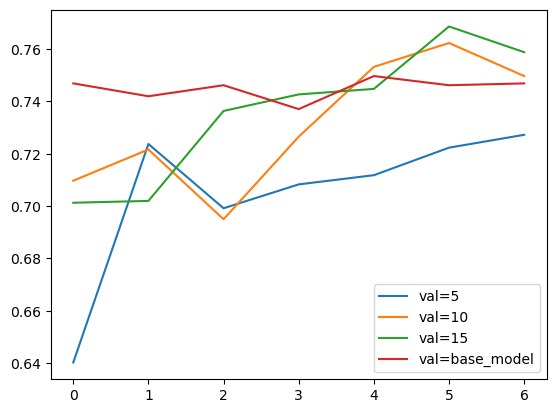

In [18]:
#tuning the rotation range parameter
scores = {}

for value in [5, 10, 15]:
    print(value)
    augmented_train = aug_generator(train_images,
                             train_labels,
                             rotation_range=value)
    scores[value] = train_model_data_augmentation(augmented_train)

for param_value, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % param_value))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

Tuning the rotation_range parameter does give better results, especially with the value 15. We will consider it in the final model.

0.05
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 364ms/step - accuracy: 0.6055 - loss: 1.3347 - val_accuracy: 0.7069 - val_loss: 0.9889
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.8789 - loss: 0.3279 - val_accuracy: 0.7349 - val_loss: 1.0302
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9019 - loss: 0.2783 - val_accuracy: 0.7265 - val_loss: 1.0968
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 362ms/step - accuracy: 0.9379 - loss: 0.1974 - val_accuracy: 0.7756 - val_loss: 1.0173
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.9374 - loss: 0.1700 - val_accuracy: 0.7602 - val_loss: 1.0284
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9511 - loss: 0.1388 - val_accuracy: 0.7728 - val_loss: 1.0392
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.9630 - loss: 0.1157 - val_accuracy: 0.7875 - val_loss: 1.1198
0.1
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.5182 - loss: 

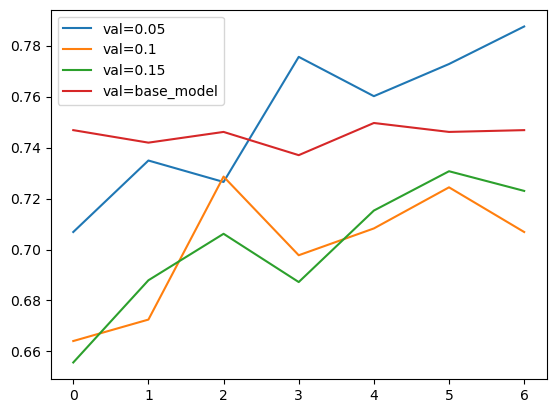

In [20]:
#tuning the height_shift_range parameter

scores = {}

for value in [0.05, 0.1, 0.15]:
    print(value)
    augmented_train = aug_generator(train_images,
                                    train_labels,
                                    height_shift_range=value)
    scores[value] = train_model_data_augmentation(augmented_train)

for param_value, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % param_value))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()


Tuning height_shift_range parameter does give better results than the base model with the value 0.05. We will consider it in the final model.

0.05
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.5842 - loss: 1.9577 - val_accuracy: 0.7181 - val_loss: 1.0163
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - accuracy: 0.9028 - loss: 0.3008 - val_accuracy: 0.7055 - val_loss: 1.2036
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9229 - loss: 0.2124 - val_accuracy: 0.6879 - val_loss: 1.2317
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 362ms/step - accuracy: 0.9312 - loss: 0.1921 - val_accuracy: 0.6999 - val_loss: 1.3936
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 360ms/step - accuracy: 0.9644 - loss: 0.1180 - val_accuracy: 0.7020 - val_loss: 1.2711
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9725 - loss: 0.0871 - val_accuracy: 0.6753 - val_loss: 1.9107
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 360ms/step - accuracy: 0.9706 - loss: 0.0997 - val_accuracy: 0.7244 - val_loss: 1.5932
0.1
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 370ms/step - accuracy: 0.5804 - loss: 

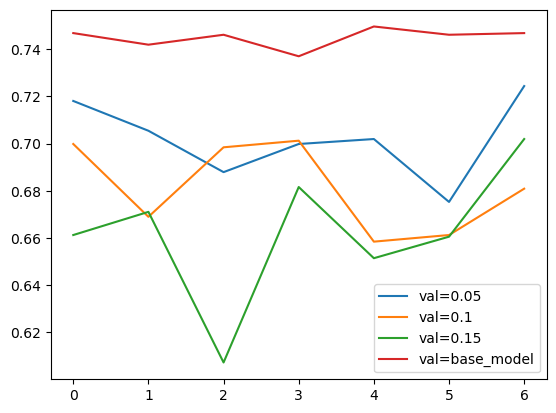

In [21]:
#tuning the zoom_range parameter

scores = {}

for value in [0.05, 0.1, 0.15]:
    print(value)
    augmented_train = aug_generator(train_images,
                                    train_labels,
                                    zoom_range=value)
    scores[value] = train_model_data_augmentation(augmented_train)

for param_value, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % param_value))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

The zoom_range parameter doesn't improve the accuracy. We will not take it in consideration.

(0.9, 1.1)
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.6671 - loss: 1.2615 - val_accuracy: 0.7349 - val_loss: 0.8750
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9576 - loss: 0.1389 - val_accuracy: 0.7686 - val_loss: 1.0474
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9878 - loss: 0.0504 - val_accuracy: 0.7314 - val_loss: 1.0491
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9962 - loss: 0.0245 - val_accuracy: 0.7398 - val_loss: 1.2096
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.9989 - loss: 0.0089 - val_accuracy: 0.7475 - val_loss: 1.3723
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.7504 - val_loss: 1.4008
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7511 - val_loss: 1.4696
(0.8, 1.2)
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.

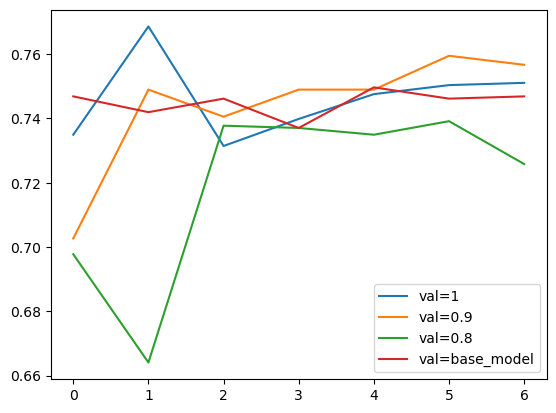

In [22]:
#tuning the brightness_range parameter

scores = {}

for value in [(0.9, 1.1), (0.8, 1.2), (0.7, 1.3)]:
    print(value)
    augmented_train = aug_generator(train_images,
                                    train_labels,
                                    brightness_range=value)
    scores[value] = train_model_data_augmentation(augmented_train)
i = 1
for param_value, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % i))
    i = i - 0.1
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

Tuning the brightness_range parameter gives us a slighlty better accuracy score (0.762) using the range value of (0.8, 1.2). We will keep it for the final model.<br> <br>We will now fix an augmented_train and augmented_val for the next fine-tuning operations.

In [32]:
# Best reached accuracy score using brightness_range=(0.8, 1,2)
augmented_train = aug_generator(train_images, train_labels, rotation_range=15, 
                                height_shift_range=0.05, brightness_range=(0.9, 1.1))
augmented_val = aug_generator_val_test(val_images, val_labels)


In [34]:
# Define the initial model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', # default learning_rate = 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using augmented data
history = model.fit(
    augmented_train,
    validation_data=augmented_val,
    epochs=nb_epochs,
    batch_size=batch_size
)

augmented_model = model
model.save("augmented_model_v1.keras")

hist_augmented_model = history.history

Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 418ms/step - accuracy: 0.5406 - loss: 3.4037 - val_accuracy: 0.6830 - val_loss: 1.1066
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 416ms/step - accuracy: 0.8366 - loss: 0.4407 - val_accuracy: 0.7181 - val_loss: 1.1731
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 421ms/step - accuracy: 0.8480 - loss: 0.3836 - val_accuracy: 0.5778 - val_loss: 1.1803
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 417ms/step - accuracy: 0.8752 - loss: 0.3427 - val_accuracy: 0.6571 - val_loss: 1.2015
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 415ms/step - accuracy: 0.8775 - loss: 0.3102 - val_accuracy: 0.7139 - val_loss: 1.0254
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 419ms/step - accuracy: 0.8947 - loss: 0.2808 - val_accuracy: 0.7370 - val_loss: 1.1201
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 419ms/step - accuracy: 0.9022 - loss: 0.2668 - val_accuracy: 0.7062 - val_loss: 1.1586


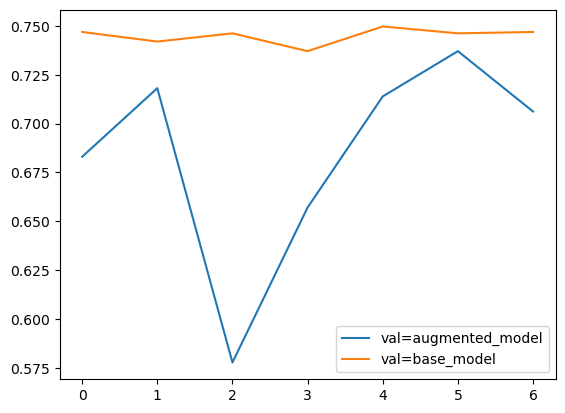

In [35]:
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

Combining the best values for data augmentation parameters tuned each apart gives a worse model. It's a difficult task to combine many transformations. We choose one transformation that gave the maximum accuracy score (0.787) which is height_shift_range=0.05 for the following models.

In [36]:
# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = augmented_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7341 - loss: 0.9242
Test Accuracy: 0.82


Even the accuracy score on test dataset is also worse 0.82 < 0.88 of base model.

In [37]:
# Best reached accuracy score using brightness_range=(0.8, 1,2)
augmented_train = aug_generator(train_images, train_labels, height_shift_range=0.05)
augmented_val = aug_generator_val_test(val_images, val_labels)

# Define the initial model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', # default learning_rate = 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using augmented data
history = model.fit(
    augmented_train,
    validation_data=augmented_val,
    epochs=nb_epochs,
    batch_size=batch_size
)

augmented_model = model
model.save("augmented_model_v2.keras")

hist_augmented_model = history.history

Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.5836 - loss: 2.1125 - val_accuracy: 0.7265 - val_loss: 0.8978
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.8759 - loss: 0.3451 - val_accuracy: 0.7546 - val_loss: 0.9115
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9083 - loss: 0.2609 - val_accuracy: 0.7405 - val_loss: 1.1088
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.9194 - loss: 0.2157 - val_accuracy: 0.7651 - val_loss: 0.9462
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.9321 - loss: 0.1931 - val_accuracy: 0.7630 - val_loss: 1.0801
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.9470 - loss: 0.1476 - val_accuracy: 0.7553 - val_loss: 1.0600
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 360ms/step - accuracy: 0.9525 - loss: 0.1377 - val_accuracy: 0.7819 - val_loss: 0.9651


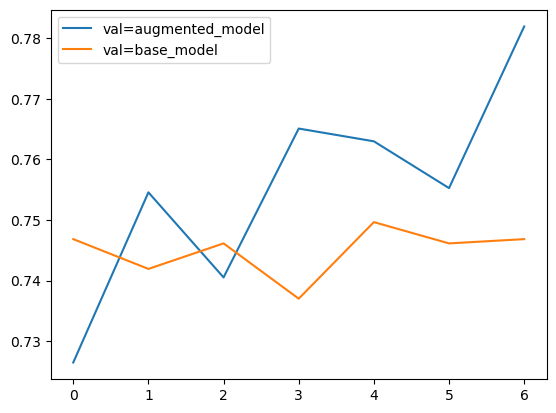

In [38]:
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

In [39]:
# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = augmented_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8071 - loss: 0.8753
Test Accuracy: 0.86


Accuracy score on test dataset is slighlty smaller 0.86 < 0.88 and loss is slightly better 0.87 < 0.92 compared to base model. We will keep this augmented model for the next trainings.

#### Tuning the learning rate parameter

In [42]:
def make_model(learning_rate):
    # Define the CNN model
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
    ])

    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [43]:
scores = {}

for parameter in [0.0001, 0.001, 0.01]:
    print(parameter)
    model = make_model(parameter)

    # Train the model
    history = model.fit(augmented_train,
                        validation_data=augmented_val,
                        epochs=nb_epochs, batch_size=32)
    
    scores[parameter] = history.history

0.0001
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.5458 - loss: 0.9897 - val_accuracy: 0.6431 - val_loss: 1.0202
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 362ms/step - accuracy: 0.8258 - loss: 0.4933 - val_accuracy: 0.6971 - val_loss: 0.9917
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.8723 - loss: 0.3783 - val_accuracy: 0.6992 - val_loss: 1.2184
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 365ms/step - accuracy: 0.8714 - loss: 0.3635 - val_accuracy: 0.7258 - val_loss: 1.0866
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - accuracy: 0.9009 - loss: 0.2931 - val_accuracy: 0.7314 - val_loss: 1.0065
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 362ms/step - accuracy: 0.9003 - loss: 0.2912 - val_accuracy: 0.7581 - val_loss: 1.0118
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.9094 - loss: 0.2648 - val_accuracy: 0.7349 - val_loss: 1.0302
0.001
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.5912 - lo

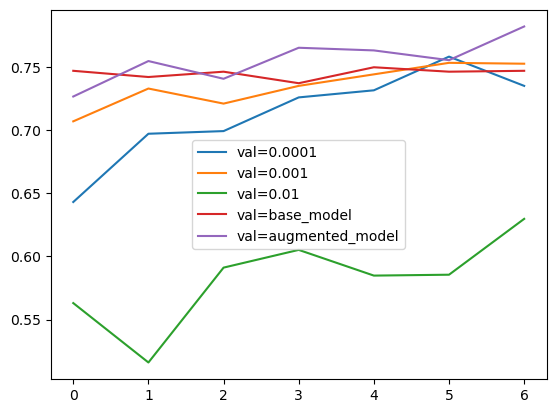

In [44]:
for parameter, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

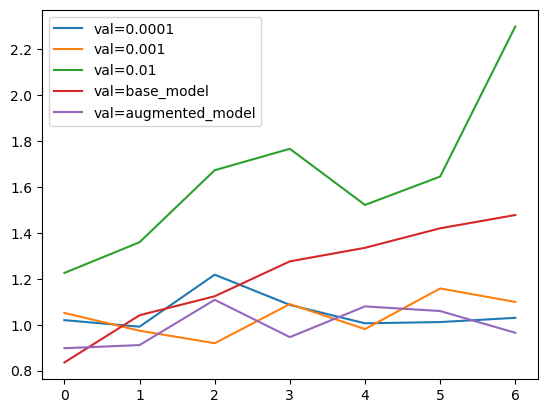

In [45]:
for parameter, hist in scores.items():
    plt.plot(hist['val_loss'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

learning_rate = 0.001 give the best accuracy scores (~0.0.757). We will keep it for final model

#### Adding more convolutional layers and an inner dense layer

Let's try with one more convolutional layer and one more inner dense layer.<br>The added convolutional layer will try to find more complex patterns than the ones found with the first convolutional layer. <br> As for the added dense layer, it will enhance the learning.

#### Tuning the size of the added convolutional layer

In [46]:
def make_model(nb_filters):
    # Define the CNN model
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(nb_filters, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
    ])

    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer='adam', # default 0.001
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [47]:
scores = {}

for parameter in [32, 64, 128]:
    print(parameter)
    model = make_model(parameter)

    # Train the model
    history = model.fit(augmented_train,
                        validation_data=augmented_val,
                        epochs=nb_epochs, batch_size=32)
    
    scores[parameter] = history.history

32
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 437ms/step - accuracy: 0.5758 - loss: 1.0546 - val_accuracy: 0.6585 - val_loss: 1.0772
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 434ms/step - accuracy: 0.8330 - loss: 0.4207 - val_accuracy: 0.6396 - val_loss: 1.1841
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 432ms/step - accuracy: 0.8837 - loss: 0.3033 - val_accuracy: 0.7328 - val_loss: 1.0091
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 436ms/step - accuracy: 0.9149 - loss: 0.2444 - val_accuracy: 0.7055 - val_loss: 1.1444
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 433ms/step - accuracy: 0.9275 - loss: 0.2128 - val_accuracy: 0.7349 - val_loss: 1.0425
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 438ms/step - accuracy: 0.9369 - loss: 0.1978 - val_accuracy: 0.7595 - val_loss: 1.2175
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 433ms/step - accuracy: 0.9459 - loss: 0.1658 - val_accuracy: 0.7321 - val_loss: 1.3830
64
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 525ms/step - accuracy: 0.5627 - loss: 1.2

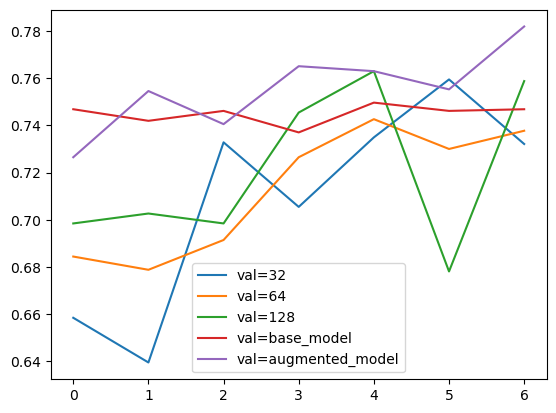

In [48]:
for parameter, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

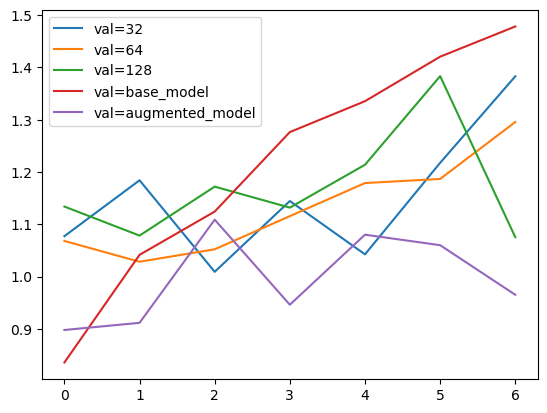

In [49]:
for parameter, hist in scores.items():
    plt.plot(hist['val_loss'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')
plt.xticks(np.arange(nb_epochs))
plt.legend()

The number of filters of 64 for the added convolutional layer Conv2D gives the best accuracy score (0.759) but it's worse then the previous best model (0.762) in terms of accuracy. But if we analyze val_loss, its value reduced from 1.6 in average to 1.4 which is a good enhancement of generalization. We will keep this added layer.

#### Tuning the size of the added inner dense layer

In [51]:
def make_model(nb_neurones):
    # Define the CNN model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(nb_neurones, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [52]:
scores = {}

for parameter in [32, 64, 128]:
    print(parameter)
    model = make_model(parameter)

    # Train the model
    history = model.fit(augmented_train,
                        validation_data=augmented_val,
                        epochs=nb_epochs, batch_size=32)
    
    scores[parameter] = history.history

32
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 398ms/step - accuracy: 0.4561 - loss: 2.1148 - val_accuracy: 0.5757 - val_loss: 1.1905
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 394ms/step - accuracy: 0.7998 - loss: 0.5496 - val_accuracy: 0.6795 - val_loss: 1.1196
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 397ms/step - accuracy: 0.8608 - loss: 0.3888 - val_accuracy: 0.7020 - val_loss: 1.0209
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.8871 - loss: 0.3256 - val_accuracy: 0.7202 - val_loss: 0.9688
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.9061 - loss: 0.2601 - val_accuracy: 0.7377 - val_loss: 0.9330
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 394ms/step - accuracy: 0.9257 - loss: 0.2130 - val_accuracy: 0.6985 - val_loss: 1.2565
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 399ms/step - accuracy: 0.9220 - loss: 0.2146 - val_accuracy: 0.7111 - val_loss: 1.1445
64
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 442ms/step - accuracy: 0.5520 - loss: 2.4

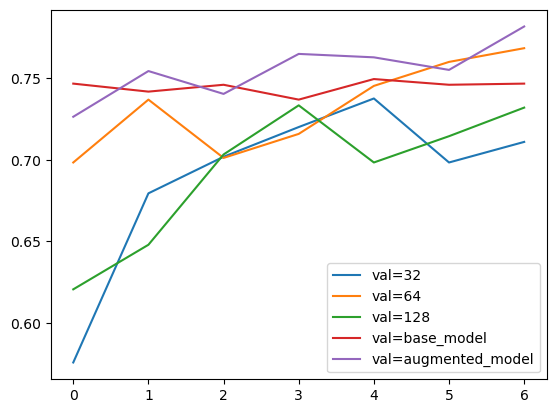

In [53]:
for parameter, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

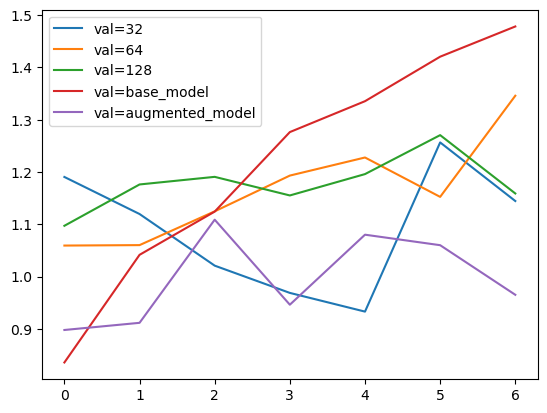

In [54]:
for parameter, hist in scores.items():
    plt.plot(hist['val_loss'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

We notice that scores are close and that at the 10th epoch, the dense layer of size 64 goes down in accuracy. We are not sure if it decreases for the later epochs or not. But overall, an inner dense layer with the size 128 is a very good choice.

#### Adding the dropout parameter and tuning it

In [55]:
def make_model(dropout):
    # Define the CNN model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'), ################
        layers.Dropout(dropout),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])

    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [56]:
scores = {}

for parameter in [0.1, 0.25, 0.5]:
    print(parameter)
    model = make_model(parameter)

    # Train the model
    history = model.fit(augmented_train,
                        validation_data=augmented_val,
                        epochs=nb_epochs, batch_size=32)
    
    scores[parameter] = history.history

0.1
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 440ms/step - accuracy: 0.5231 - loss: 3.2200 - val_accuracy: 0.6711 - val_loss: 0.9410
Epoch 2/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.8166 - loss: 0.4539 - val_accuracy: 0.7244 - val_loss: 0.9632
Epoch 3/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 438ms/step - accuracy: 0.8800 - loss: 0.3238 - val_accuracy: 0.7118 - val_loss: 0.9581
Epoch 4/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 437ms/step - accuracy: 0.9033 - loss: 0.2610 - val_accuracy: 0.7286 - val_loss: 0.9021
Epoch 5/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 442ms/step - accuracy: 0.9191 - loss: 0.2187 - val_accuracy: 0.7230 - val_loss: 0.9595
Epoch 6/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 445ms/step - accuracy: 0.9424 - loss: 0.1710 - val_accuracy: 0.7272 - val_loss: 1.1396
Epoch 7/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - accuracy: 0.9378 - loss: 0.1783 - val_accuracy: 0.7525 - val_loss: 1.0257
0.25
Epoch 1/7
134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 442ms/step - accuracy: 0.4665 - loss: 

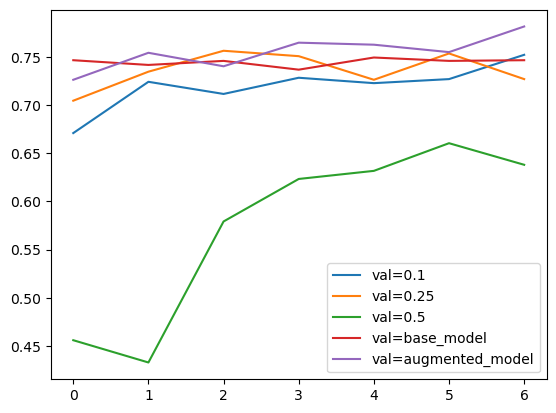

In [57]:
for parameter, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

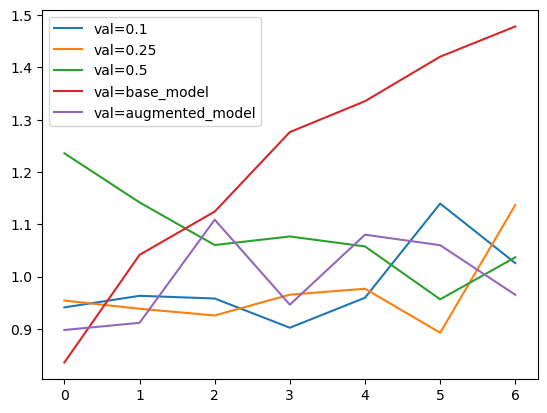

In [58]:
for parameter, hist in scores.items():
    plt.plot(hist['val_loss'], label=('val=%s' % parameter))
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')

plt.xticks(np.arange(nb_epochs))
plt.legend()

We notice that most of the time, the best accuracy score are the ones related to a dropout rate of 0.1. We will keep this value for training our final model.

#### Training the best model and saving it

In [59]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 classes
])

learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# To save the best model reached at each epoch
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Compile the model
model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model
history = model.fit(augmented_train,
    validation_data=augmented_val,
    epochs=30, batch_size=32,
    callbacks=[checkpoint])



Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 526ms/step - accuracy: 0.6010 - loss: 0.9633 - val_accuracy: 0.6816 - val_loss: 1.1139
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 525ms/step - accuracy: 0.8563 - loss: 0.3845 - val_accuracy: 0.6879 - val_loss: 1.1204
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 70s 523ms/step - accuracy: 0.8905 - loss: 0.2846 - val_accuracy: 0.6928 - val_loss: 1.1268
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 526ms/step - accuracy: 0.9231 - loss: 0.2251 - val_accuracy: 0.7160 - val_loss: 1.1271
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 70s 523ms/step - accuracy: 0.9248 - loss: 0.2072 - val_accuracy: 0.7293 - val_loss: 1.1182
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 528ms/step - accuracy: 0.9425 - loss: 0.1721 - val_accuracy: 0.7440 - val_loss: 1.1890
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 526ms/step - accuracy: 0.9465 - loss: 0.1389 - val_accuracy: 0.7511 - val_loss: 1.3018
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 528ms/step - accuracy: 0.9650 - loss: 0

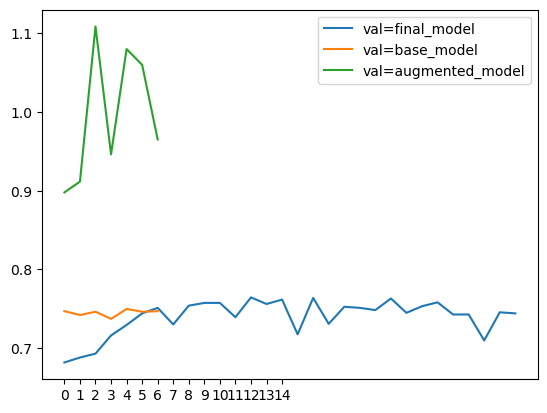

In [60]:
plt.plot(history.history['val_accuracy'], label='val=final_model')
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')
plt.xticks(np.arange(15))
plt.legend()

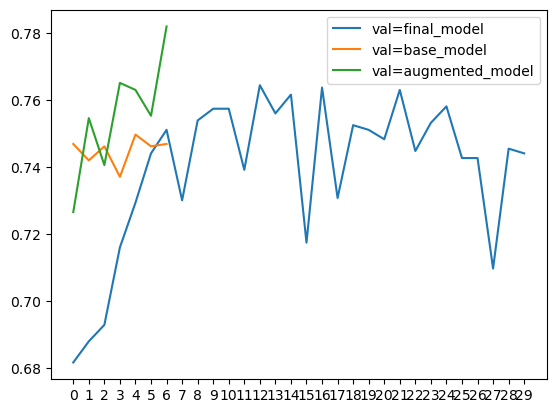

In [62]:
plt.plot(history.history['val_accuracy'], label='val=final_model')
plt.plot(hist_base_model['val_accuracy'], label='val=base_model')
plt.plot(hist_augmented_model['val_accuracy'], label='val=augmented_model')
plt.xticks(np.arange(30))
plt.legend()

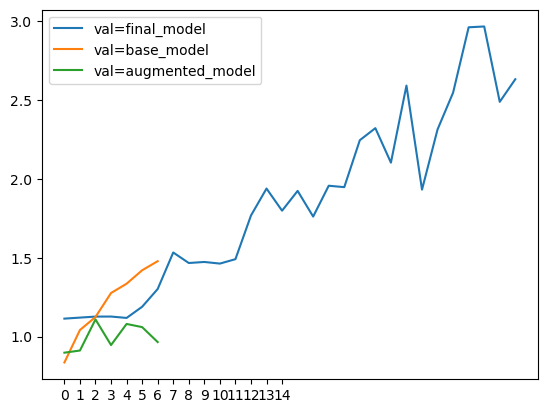

In [61]:
plt.plot(history.history['val_loss'], label='val=final_model')
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')
plt.xticks(np.arange(15))
plt.legend()

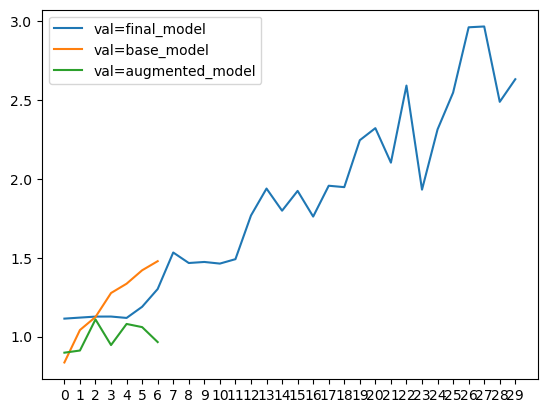

In [63]:
plt.plot(history.history['val_loss'], label='val=final_model')
plt.plot(hist_base_model['val_loss'], label='val=base_model')
plt.plot(hist_augmented_model['val_loss'], label='val=augmented_model')
plt.xticks(np.arange(30))
plt.legend()

#### Using the final model on testing dataset

In [10]:
from tensorflow import keras

In [12]:
# Loading the best model (according to best epoch's accuracy score)
model = keras.models.load_model('model_v1_15_0.771.keras') #########################################

I0000 00:00:1737305687.424918     158 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-19 16:54:47.429222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# test dataset generator with resizing
test_gen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
)

# Test generator
test_ds = test_gen.flow_from_directory(
    'brain-tumor-mri-dataset/versions/1/Testing',              # Path to dataset directory
    target_size=input_size,  # Resize images
    batch_size=32,           # Number of images per batch
    class_mode='categorical',# For multi-class classification
    shuffle=False             # Shuffle data to ensure randomness
)

Found 1311 images belonging to 4 classes.


In [14]:
# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8419 - loss: 0.9329
Test Accuracy: 0.89


In [15]:
# Loading the best model (according to best epoch's accuracy score)
augmented_model = keras.models.load_model('augmented_model_v2.keras') 

# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = augmented_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8071 - loss: 0.8753
Test Accuracy: 0.86


In [16]:
# Loading the best model (according to best epoch's accuracy score)
base_model = keras.models.load_model('base_model.keras') 

# Evaluate the model using the best model (according to best epoch's accuracy score)
test_loss, test_accuracy = base_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8457 - loss: 0.9294
Test Accuracy: 0.88
